## Student Name: 

---

# Tutorial 3: Samples, histograms, EDF and EDF-based statistics

All the parts that require action (either in the code or equations) are flagged by `<your turn>` or $\color{red}{<your~turn>}$

In [1]:
import numpy as np
import emcee
from scipy.integrate import quad
import scipy.stats as st
from scipy.misc import derivative
from scipy.optimize import curve_fit, minimize, fsolve
import matplotlib.pylab as plt
import matplotlib.colors as colors


# If you have astropy, uncomment the following (optional)
from astropy.visualization import hist

plt.rc('font', family='serif')

# Below is a set of colors for matplotlib that is colorblind-friendly
# To use them in plotting commands, you can simply set "color=colorset[N]",
# where N is an integer in [0,16), reflecting the index of the colors below.
colorset = ['#000000','#00270C','#00443C','#005083',
            '#034BCA','#483CFC','#9C2BFF','#EB24F4',
            '#FF2DC2','#FF4986','#FF7356','#FFA443',
            '#EBD155','#D3F187','#D7FFC8','#FFFFFF']

We have a sample of values (measurements) $X=\{x_i\}$, and we want to test the hypothesis that weather this sample is drawn from a specific distribution.

In [2]:
sample = np.loadtxt('Data_T3_samp1.txt')

## Plot a histogram of the data

The histogram function from astropy `astropy.visualization.hist` has been imported as `hist`. Use this function to plot the **normalized** histogram. Play with binning options and make a choice based on the lecture.

If you don't have `astropy` installed, you can use the matplotlib version (which does not have `kunth` or `blocks` availabe).

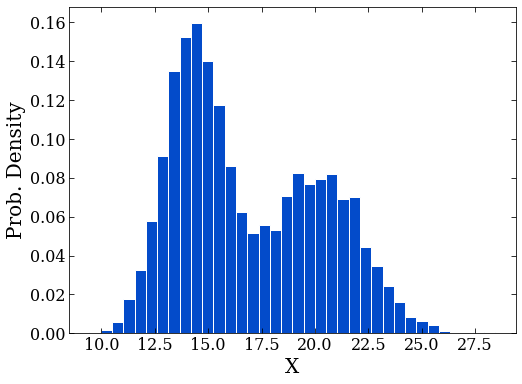

In [3]:
# Initiating the figure
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
# <your turn> : add your plotting commands here. If you label them properly, they will show up in the legend.
hist(sample,bins='knuth',density=True,edgecolor='w',ax=ax,color=colorset[4])

# Plot cosmetics - feel free to edit.
ax.set_xlabel('X',fontsize=20)
ax.set_ylabel('Prob. Density',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='major', length=5)
ax.tick_params(axis='both', which='minor', length=2.5)
ax.tick_params(axis='both', which='both',direction='in',right=True,top=True)

## Write a python function that returns the EDF function and plot the EDF.

$$\displaystyle \hat{F}_n(t) = \frac{\textrm{number of elements}\leq t}{n} = \frac{1}{n} \sum_{i=1}^n 1_{X_i\leq t}$$

Note 1: values of $X$ should be sorted for an EDF.

Note 2: For plotting the EDF as a step function, you can consider using `step` in matplotlib.

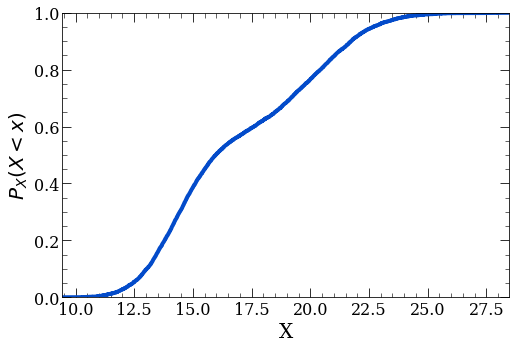

In [4]:
def emperical_cdf(data):
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return x, y

sample_edfx, sample_edfy = emperical_cdf(sample)

fig = plt.figure(figsize=(8,6))
ax1 = plt.subplot2grid((8,1),(0,0),fig=fig,rowspan=7)

ax1.step(sample_edfx, sample_edfy, where='post',lw=4,color=colorset[4])
ax1.set_xlabel('X',fontsize=20)
ax1.set_ylabel(r'$P_X(X < x)$',fontsize=20)
ax1.set_xlim(sample.min(),sample.max())
ax1.set_ylim(0,1)
ax1.minorticks_on()
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(axis='both', which='major', length=9)
ax1.tick_params(axis='both', which='minor', length=4.5)
ax1.tick_params(axis='both', which='both',direction='in',right=True,top=True)

## What type of distribution(s) do you think the sample maybe drawn from? 

Based on your answer, write a mixture likelihood to model your hypothesized underlying distribution, and find the best-fit values for the distribution parameters.

$$\displaystyle \ln \text{L} = \sum_{i=1}^N \ln\left[\sum_{j=1}^{M} \alpha_j \mathcal{D_j}(\theta_j|x_i)\right]$$

Note 1: `minimize` can be given `bound`, so that the optimization only happens around the region of interest.

Note 2: in `minimize` for this task, I recommend setting `method='Nelder-Mead'`.

In [5]:
def mixture_negloglike(theta, data):
    mu1, mu2, sd1, sd2, a1 = theta
    return -np.sum(np.log(a1 * st.norm(mu1,sd1).pdf(data) + (1-a1) * st.norm(mu2,sd2).pdf(data)))

best_fit = minimize(mixture_negloglike,[14,21,1,1,0.5],sample,bounds=[(12,16),(16,22),(0.1,10),(0.1,10),(0,1)],method='Nelder-Mead')
print(best_fit)

 final_simplex: (array([[14.2845339 , 20.0847342 ,  1.38017375,  2.15741908,  0.54837717],
       [14.28448529, 20.08466532,  1.38020206,  2.15742444,  0.54837108],
       [14.28453679, 20.08478679,  1.38025482,  2.15738181,  0.54838132],
       [14.28454214, 20.08471   ,  1.38023328,  2.15736171,  0.5483693 ],
       [14.28454017, 20.08477268,  1.38020408,  2.15732324,  0.5483853 ],
       [14.28456885, 20.08470415,  1.38019324,  2.15739673,  0.54838941]]), array([22539.86234889, 22539.86235104, 22539.86235111, 22539.86235332,
       22539.86235388, 22539.86235584]))
           fun: 22539.862348885083
       message: 'Optimization terminated successfully.'
          nfev: 299
           nit: 180
        status: 0
       success: True
             x: array([14.2845339 , 20.0847342 ,  1.38017375,  2.15741908,  0.54837717])


## Write a function for your model's PDF, and plot it against the data histogram.

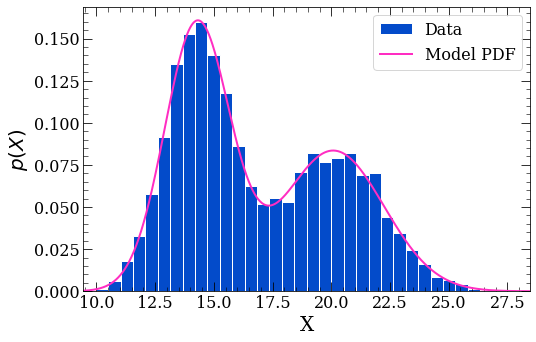

In [6]:
def model_pdf(x, theta=best_fit.x):
    mu1,mu2,sd1,sd2,a1 = theta
    return a1 * st.norm(mu1,sd1).pdf(x) + (1-a1) * st.norm(mu2,sd2).pdf(x)

mo_pdf_x = np.linspace(sample.min(),sample.max(),1000)
mo_pdf_y = model_pdf(mo_pdf_x)

fig = plt.figure(figsize=(8,6))
ax1 = plt.subplot2grid((8,1),(0,0),fig=fig,rowspan=7)
hist(sample,bins='knuth',density=True,edgecolor='w',ax=ax1,color=colorset[4],label='Data')
ax1.plot(mo_pdf_x,mo_pdf_y,color=colorset[8],label='Model PDF',lw=2)
ax1.legend(fontsize=16)
ax1.set_xlabel('X',fontsize=20)
ax1.set_ylabel(r'$p(X)$',fontsize=20)
ax1.set_xlim(sample.min(),sample.max())
ax1.minorticks_on()
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(axis='both', which='major', length=9)
ax1.tick_params(axis='both', which='minor', length=4.5)
ax1.tick_params(axis='both', which='both',direction='in',right=True,top=True)

## Write a function for your model's CDF, and Plot it against the data EDF.

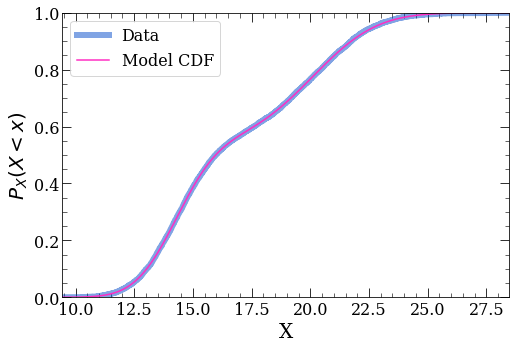

In [7]:
def model_cdf(x, theta=best_fit.x):
    mu1,mu2,sd1,sd2,a1 = theta
    return a1 * st.norm(mu1,sd1).cdf(x) + (1-a1) * st.norm(mu2,sd2).cdf(x)

mo_cdf_x = np.linspace(sample.min(),sample.max(),1000)
mo_cdf_y = model_cdf(mo_cdf_x)

fig = plt.figure(figsize=(8,6))
ax1 = plt.subplot2grid((8,1),(0,0),fig=fig,rowspan=7)
ax1.step(sample_edfx, sample_edfy, where='post',lw=6,color=colorset[4],alpha=0.5,label='Data')
ax1.plot(mo_cdf_x,mo_cdf_y,color=colorset[8],label='Model CDF')
ax1.legend(fontsize=16)
ax1.set_xlabel('X',fontsize=20)
ax1.set_ylabel(r'$P_X(X < x)$',fontsize=20)
ax1.set_xlim(sample.min(),sample.max())
ax1.set_ylim(0,1)
ax1.minorticks_on()
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(axis='both', which='major', length=9)
ax1.tick_params(axis='both', which='minor', length=4.5)
ax1.tick_params(axis='both', which='both',direction='in',right=True,top=True)

## Can we reject the null hypothesis (i.e., that the sample is drawn from our model distribution)?

While A-D is a superior test for this as we discussed, for the simple case here, let's use the K-S test.

In [8]:
st.ks_1samp(sample,model_cdf)

KstestResult(statistic=0.004030714138365116, pvalue=0.9984744808962407)

As we discussed, this result comes with a caveat that these tests can be inaccurate if the model is derived from the data being evaluated.

### One last note
If you were to "fit" a single distribution (e.g., a single normal dist or something else), as we discussed in the lecture, you just need the appropriate estimators. Note that this is implemented in the distributions in `scipy.stats`, so you can simply find the "best-fit" values of sample estimators that would correspond to a hypothesized distribution. For example:

In [9]:
st.norm.fit(sample)

(16.904093381183806, 3.388025681428711)

In [10]:
st.laplace.fit(sample)

(15.962882965225338, 2.884793945645218)

**Remember**, having best-fit values does not mean the model/distribution is appropriately desciribing the data. As you can see that if you perform any EDF tests.

## You can now save the notebook and download it.